In [3]:
import csv
import os
import os.path as op
import time

import foolbox
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import numpy as np
from numpy.random import choice
from sklearn.decomposition import PCA
import torch
import umap

from dataset import make_data_loaders
from model import load_layers
from utils import load_config_dataset
from utils import SEARCH
import nb_utils

In [4]:
# If you want to store the figures, change the path below
STORE_GRAPH = None

In [5]:
if 'science' in plt.style.available:
    plt.style.reload_library()
    plt.style.use(['science'])

In [6]:
blues = cm.get_cmap('Blues')
greens = cm.get_cmap('Greens')
reds = cm.get_cmap('Oranges')
device ='cuda:0'
font_size=25

In [7]:
labels_dict = {
    'CIFAR10':{
        0 :'airplane',
        1:'automobile',
        2:'bird',
        3:'cat',
        4:'deer',
        5:'dog',
        6:'frog',
        7:'horse',
        8:'ship',
        9:'truck'
    },
    'STL10':{
        0 :'airplane',
        1:'bird',
        2:'car',
        3:'cat',
        4:'deer',
        5:'dog',
        6:'horse',
        7:'monkey',
        8:'ship',
        9:'truck'
    },
}

## Figure 1

No results found for 1 layer. Using past results.
No results found for 2 layer. Using past results.
No results found for 3 layer. Using past results.
---Save not available


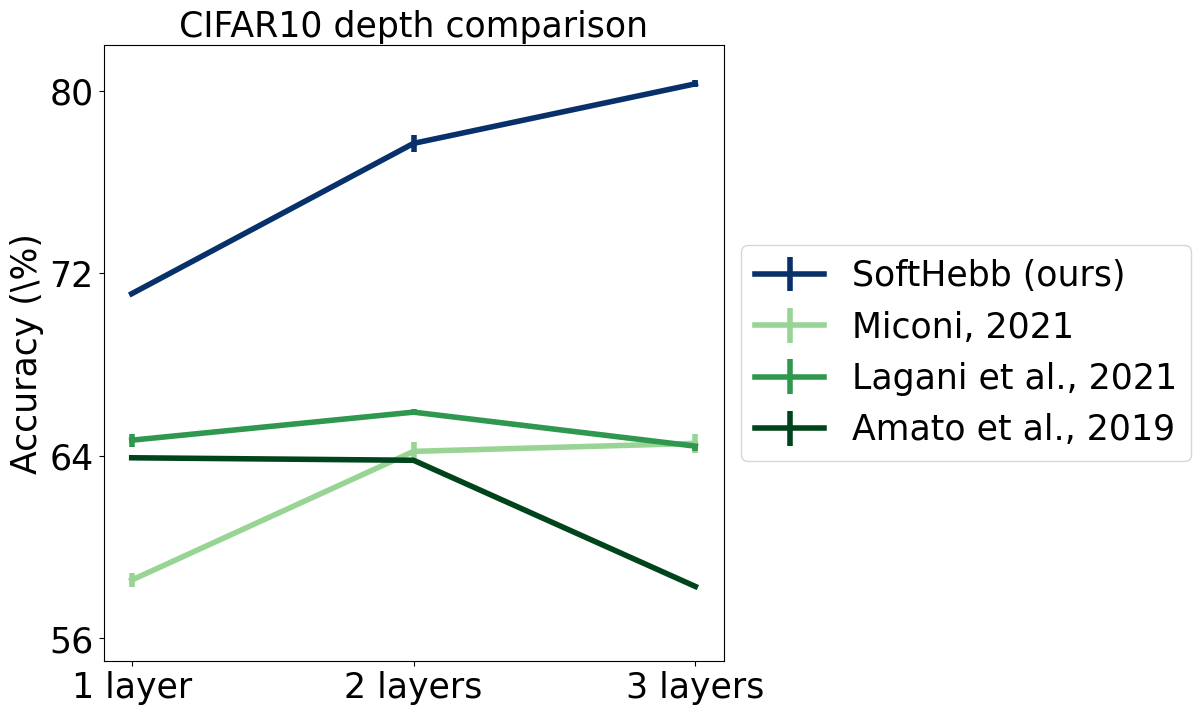

In [8]:
green = cm.get_cmap('Greens')
x= ['1 layer', '2 layers', '3 layers']
# Our results with 4 seeds
softhebb_results_mean = [71.11,77.7,80.31]
softhebb_results_std = [0.063442888,0.383234589,0.148421936]
# Try to load results
for n_layers in [2,3,4]:
    try:
        mean, std = nb_utils.get_mean_std(os.path.join(SEARCH, f'CIFAR10_SoftHebb{n_layers}'))
        softhebb_results_mean[n_layers-2] = mean
        softhebb_results_std[n_layers-2] = std
    except:
        print(f'No results found for {n_layers-1} layer. Using past results.')
        
y = [
    [63.92,63.81,58.28],
    [64.69,65.92,64.43],
    [58.56,64.2,64.55],
    softhebb_results_mean,
]
error=[[0.,0,0],
       [0.29,0.14,0.21],
       [0.3,0.4,0.4],
       softhebb_results_std
]
font_size=25
label = ['Amato et al., 2019','Lagani et al., 2021','Miconi, 2021', 'SoftHebb (ours)']
colors = [green(i) for i in np.linspace(0.4,1,3)][::-1] + [ plt.cm.Blues(1.0)]
plt.rcParams.update({'font.size': 40,
                    'lines.linewidth':4,
                    'lines.linestyle':'-',
                    'lines.markersize':1})
fig =  plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)#, aspect=0.08)
for i in range(len(label))[::-1]:
    plt.errorbar(x, y[i], error[i], color=colors[i], label=label[i])
plt.ylabel("Accuracy (\%)", fontsize=font_size)
#plt.xlabel("#layer")
plt.title("CIFAR10 depth comparison", fontsize=font_size)
plt.ylim((55,82))
plt.xticks([0, 1, 2],x, fontsize=font_size)
plt.minorticks_off()
#ax.set_xticks(ax.get_xticks()[1:])
#ax.set_xticks([])
plt.yticks(np.linspace(56, 80,4), fontsize=font_size)

plt.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))
try:
    fig.savefig(op.join(STORE_GRAPH, 'depth_comparison.png'))
    fig.savefig(op.join(STORE_GRAPH, 'depth_comparison.svg'), format='svg')
except:
    print('---Save not available')

## Figure 2

In [9]:
name_model = 'SoftHebb_STL'
name_model = 'STL10_SoftHebb5'
# Figure 2
n_neurons_per_layer = 72
# Figures B.8, B.9, B.10, B.11 will all be generated when uncommenting next line
# n_neurons_per_layer = 250

model_checkpoint = nb_utils.find_checkpoint(os.path.join(SEARCH, name_model))
assert model_checkpoint is not None, "Checkpoint of trained model not found"
print(model_checkpoint)
model = nb_utils.resume_model(name_model, model_path_override=os.path.join(model_checkpoint, 'checkpoint.pth.tar'))

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:Users\\huaclark\\workspace\\results\\hebb\\search\\STL10_SoftHebb5'

In [ ]:
# Order weight for a better visualization
weights = []
w_indices = []
from torch.nn import Linear
for i in range(len(model.blocks)):
    if isinstance(model.blocks[i].layer, Linear):
        continue
    weight = model.blocks[i].layer.weight.detach().cpu()
    out_channel, in_channel, k1, k2 = weight.shape
    weight_reshape = weight.reshape((out_channel, in_channel, (k1 * k2)))
    order = weight_reshape.std(2).mean(1)
    sorted, indices = torch.sort(order)
    w_indices.append(indices)
    weight = weight[indices]
    weights.append(weight)

In [ ]:
w_indices = [np.random.choice(iw.shape[0], size=min(n_neurons_per_layer, iw.shape[0]), replace=False) for iw in weights]
NL = len(weights)
receptive_fields = [5, 12, 26, 54]
samples_per_objective = 1
batch_size = 1
exp_name = 'PGD_L2_randomStart'
random_start = True
load_samples = False
overwrite = True

In [ ]:

neurons_per_layer = [ids[:n_neurons_per_layer] for ids in w_indices]

# ============== Based on std of filters ========================
og_w_indices = w_indices
new_w_indices = []
from torch.nn import Linear
for i in range(len(model.blocks)):
    if isinstance(model.blocks[i].layer, Linear):
        continue
    weight = model.blocks[i].layer.weight.detach().cpu()
    out_channel, in_channel, k1, k2 = weight.shape
    weight_reshape = weight.reshape((out_channel, in_channel, (k1 * k2)))
    order = weight_reshape.std(2).mean(1)
    order = order[og_w_indices[i]]
    _, indices = torch.sort(order)
    new_w_indices.append(og_w_indices[i][indices]) 
    

neurons_per_layer = [ids[:n_neurons_per_layer] for ids in new_w_indices]
epsilons = np.array([255]) / 255
figs, imgs, successs, accs = [], [], [], []


for l in range(NL):
    print(f"  \\\\\\\\\\\\\\\\\\\\\\\\\\\ Layer {l} \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\ ")
    h_w = receptive_fields[l]
    model = nb_utils.resume_model(name_model, model_path_override=os.path.join(model_checkpoint, 'checkpoint.pth.tar'))
    fig = plt.figure(figsize=(np.sqrt(len(neurons_per_layer[l])), np.sqrt(len(neurons_per_layer[l]))))
    for i_n, n in enumerate(neurons_per_layer[l]): 
        print(f" ===================== Neuron {n} ({i_n}-th) ===================== ")
        #ax = plt.subplot(np.ceil(np.sqrt(N[topl-1])),np.ceil(np.sqrt(N[topl-1])),i_n+1)
        ax = plt.subplot(np.ceil(np.sqrt(len(neurons_per_layer[l]))),np.ceil(np.sqrt(len(neurons_per_layer[l]))),i_n+1)
        #model = resume_model(name_model)
        i_model = model.blocks[:l+1]
        for prev_l in range(l):
            i_model[prev_l].pool.padding = 0
            i_model[prev_l].layer.F_padding, i_model[prev_l].layer.F_pad = 0, False
        i_model[-1].layer.F_padding, i_model[-1].layer.F_pad = 0, False
        i_model[-1].activation = None # remove last activation to max negative values too
        i_model[-1].pool = None # remove pooling in last layer
        i_model.add_module(str(len(i_model)), nb_utils.ChooseNeuronFlat(n))
        i_model.eval()
        model.to(device)
        for s in range(samples_per_objective):
            print(f" ===================== Sample {s} ===================== ")
            filename = f"images/receptive_fields/FigRFs_{exp_name}/L_{l}_N_{n}_S_{s}.npy"
            
            if not os.path.isdir(os.path.dirname(filename)):
                os.makedirs(os.path.dirname(filename))
            if load_samples or (os.path.isfile(filename) and not overwrite):
                print('Loading existing image')
                with open(filename, 'rb') as f:
                    img_to_plot = np.load(f)
                    # add sample dim (redundant as will be indexed) and batch dim
                    img = torch.tensor(img_to_plot.transpose(2, 0, 1)[np.newaxis, np.newaxis, :, :, :]).to(device)
            else:
                data = torch.zeros(batch_size,3,h_w,h_w, device=torch.device(device))
                # Might have to edit /username/anaconda3/envs/softhebb/lib/python3.8/site-packages/foolbox/attacks/base.py
                criterion = nb_utils.SingleMax(max_val = 1e10, eps = 1e-05)
                img, _, success = nb_utils.attack_model(i_model, data.clone(), None, epsilons, step_size=0.001, iterations=500,
                                               random_start=random_start, nb_start=1, criterion=criterion, device=device)
                img_to_plot = img[s, 0].transpose(-3,-2).transpose(-2,-1).cpu().numpy()
                with open(filename, 'wb') as f:
                    np.save(f, img_to_plot)
        ax.imshow(img_to_plot)
        # In case you want titles
        #ax.set_title(f'N {n}, Act {i_model(img[-1]).item():.1f}', size=4, y=1.0)
        ax.set_axis_off()
        fig.tight_layout()
        k1, k2, in_c = img_to_plot.shape
        assert in_c == 3
        print(f'STD {img_to_plot.reshape((k1 * k2), in_c).std(0).mean()}')
        
    figs.append(fig)
    imgs.append(img)
    successs.append(success)
    acc = (1 - success.cpu().numpy().mean(axis=-1)) * 100
    accs.append(acc)
    # print("for model {}, took Time : {}".format(name, 
    #             time.strftime("%H:%M:%S", time.gmtime(time.time() - t))))
    for eps, a in zip(epsilons, acc):
        print("Epsilon: {} tTest Accuracy = {}".format(eps, a))

In [ ]:
# # Uncomment to store resulting figures
# for numl in range(NL):
#     file = "FigRFs"+str(numl+1)+f"_{exp_name}_{n_neurons_per_layer}"
# #     with open(file+".npy", 'wb') as f:
# #         np.save(f, w_indeces[numl])
#     figs[numl].savefig(file+".pdf", format='pdf')
#     figs[numl].savefig(file+".png")

## Figure 3

In [ ]:
dataset = 'STL10'

In [ ]:
x_step = 1
width = x_step/1.5
models = ['SoftHebb', 'Hard WTA',  'Random', 'Backprop e2e']
# models = ['SoftHebb',]
label2model = {'SoftHebb': 'SoftHebb', 'Hard WTA': 'HardWTA',  'Random': 'Random', 'Backprop e2e': 'BP'}
if dataset == 'CIFAR10':
    nb_layer = 3
    ratio=0.4
    x =models *nb_layer
    
    y_ticks =np.linspace(57, 84, 4)
    y_lim =(56,89)
    acc_means = [71.10, 62.69,  63.99, 72.42,
                 77.70,60.08,  68.64, 82.49, 
                 80.31, 60.29,  64.62,  83.97]
    acc_stds = [0.06, 0.47,  0.21, 0.22, 0.24,
                0.38,0.49, 0.24, 0.35, 0.12, 
                0.14,0.47,0.25, 0.15,0.07]        
    
    
    x_pos = [x_step*i+x_step*((i > 3)+(i > 7)) for i in range(len(x))]
    
elif dataset == 'CIFAR100':
    nb_layer = 3
    ratio=0.4
    x = models*nb_layer
    
    y_ticks =np.linspace(20, 56, 4)
    y_lim =(19,60)
    acc_means = [43.00, 34.34, 34.59, 44.76,
                 52.31,33.49,  38.76, 52.11, 
                 56.0,21.6, 38.25,  57.19]
    acc_stds = [0.16,0.49,  0.21, 0.88, 0.14,
                0.14,0.51, 0.24, 0.4, 0.21, 
                0.14,1.,0.25, 0.87, 0.07]
    
    
    x_pos = [x_step*i+x_step*((i > 3)+(i > 7)) for i in range(len(x))]

elif dataset == 'STL10':
    nb_layer = 4
    ratio=0.5
    x = models*nb_layer
    
    y_ticks =np.linspace(52, 79, 4)
    y_lim =(51,80)
    acc_means = [65.4,57.92, 62.55, 67.5,
                 70.11,58.4,  65.69, 69.64, 
                 73.1,54.31,  68.12,  72.93,
                 76.23, 54.84,  68.19,  74.51]
    acc_stds = [0.18,0.41,  0.64, 0.1,
                0.20,0.15,  0.30, 0.21, 
                0.23,0.23,0.28,0.12,
                 0.19,0.56,0.34,0.36]
    
    x_pos = [x_step*i+x_step*((i > 3)+(i > 7)+(i > 11)+(i > 15)) for i in range(len(x))]

elif dataset == 'ImageNette':
    nb_layer = 5
    x = models*nb_layer
    ratio=0.6
    y_ticks =np.linspace(53, 86, 4)
    y_lim =(51,88)
    acc_means = [61.03,56.77,  61, 61.91,
                 71.29,60.79, 67.31, 72.32, 
                 75.69,60.66, 68.12,  76.48,
                 78.76,59.60, 74.2,  81.5,
                80.98,61.2, 74.1,  85.3]
    acc_stds = [0.32,0.41,  0.64, 0.21,
                0.7,0.15,  0.30, 0.21, 
                0.12,0.23,0.28,0.12,
                 0.23,0.56,0.34,0.36,
               0.43,0.56,0.34,0.45]
    
    x_pos = [x_step*i+x_step*((i > 3)+(i > 7)+(i > 11)+(i > 15)) for i in range(len(x))]
else:
    raise ValueError


# try to load results instead of previous hardcoded results
for i_layer in range(1, nb_layer+1):
    for i_model, model_label in enumerate(models):
        try:
            mean, std = nb_utils.get_mean_std(os.path.join(SEARCH, f'{dataset}_{label2model[model_label]}{i_layer+1}'))
            acc_means[(i_layer-1)*len(models)+i_model] = mean
            acc_stds[(i_layer-1)*len(models)+i_model] = std    
        except Exception as e:
            print(e)
            print(f'Could not load {model_label} with {i_layer+1} layers. Using past results.')
#             if model_label == 'SoftHebb' and i_layer+1 == 2:
#                 import pdb
#                 pdb.set_trace()
                
x_tick_pos = x_pos

rgb0 ='C4'
rgb1 ='C0'
rgb2 ='C1'
rgb3 ='C2'
rgb4 ='C3'
rgb5 ='C5'
colors = [blues(1.0), greens(1.0), greens(0.6), greens(0.4)]*nb_layer

font_size = 25

plt.rcParams.update({'font.size': 15})
plt.close('all')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect=ratio)
for i in range(len(x)):
    plt.bar(x_pos[i], acc_means[i], yerr=acc_stds[i], color=colors[i], width=width, label=x[i] if i<len(x)/nb_layer else None)
plt.ylabel("Accuracy (\%)", fontsize=font_size)
# plt.xlabel("Model")
#plt.title("Depth scaling", fontsize=font_size)
plt.ylim(y_lim)
#plt.xticks(x_tick_pos, x, fontsize=14)
ax.set_xticks([])
plt.yticks(y_ticks, fontsize=font_size)


if dataset=='CIFAR10':
    plt.legend(fontsize=font_size)


minorticks_loc = [x_step*1.5, 6.49*x_step, 11.49*x_step, 16.49*x_step, 21.49*x_step]
ax.xaxis.set_minor_locator(ticker.FixedLocator(minorticks_loc))
# ax.set_xticklabels(['\n1 Layer', '\n2 Layers'], minor=True)
ax.set_xticklabels(['1 layer', '2 layers', '3 layers', '4 layers', '5 layers'], minor=True, fontsize=font_size)
plt.tick_params(axis='x', which='minor', length=2, pad=5)
#plt.minorticks_off()

ax.yaxis.set_tick_params(which='minor', bottom=False)
# ax.tick_params(axis=u'both', which=u'both')
for i, v in enumerate(acc_means):
    plt.text(x_pos[i]-0.5, v + 0.5, '{:.1f}'.format(v), color='black', fontsize=20)
# ax.xaxis.set_minor_locator([0.5, 3])
# ax.xaxis.set_minor_formatter(['\nHard WTA', '\nSoftHebb'])
# ax.tick_params(axis='x', which='minor', length=0)
plt.show()
try:
    fig.savefig(op.join(STORE_GRAPH, 'Depth_'+dataset+'.png'))
    fig.savefig(op.join(STORE_GRAPH, 'Depth_'+dataset+'.svg'), format='svg')
except:
    print('---Save not available')

## Figure 4

In [ ]:
x = ['1 layer', '2 layers', '3 layers']


acc_means = [[71.09497168,71.69210782,66.43911384],[71.09497168,74.85187749,73.86927136], [71.09497168,77.69155189,80.30996171]]
acc_stds = [[0.063442888,0.23742104,0.343656806],[0.063442888,0.305399329,0.328176782],[0.063442888,0.383234589,0.148421936]]
# try to load results instead of previous hardcoded results
for i_layer in range(1, len(x)+1):
    for i_model, model_label in enumerate(['wf1', 'wf2', 'wf4']):
        model_label = '' if (model_label == 'wf4' or i_layer == 1) else f'_{model_label}'
        try:
            mean, std = nb_utils.get_mean_std(os.path.join(SEARCH, f'CIFAR10_SoftHebb{i_layer+1}{model_label}'))
            acc_means[i_model][i_layer-1] = mean
            acc_stds[i_model][i_layer-1] = std    
        except:
            print(f'Could not load {model_label} with {i_layer+1} layers. Using past results.')

    
x_step = 1
width = x_step/1.5
x_pos = [x_step*i+x_step/2*((i > 2)+(i > 5)) for i in range(9)]
x_tick_pos = x_pos


rgb0 ='C4'
rgb1 ='C0'
rgb2 ='C1'
rgb3 ='C2'
rgb4 ='C3'
rgb5 ='C5'

font_size = 25

colors = [blues(i) for i in np.linspace(0.4,1,3)]*3

plt.rcParams.update({'font.size': 18,
                    'lines.linewidth':4,
                    'lines.linestyle':'-',
                    'lines.markersize':1})
plt.close('all')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, aspect=0.2)
for i in range(len(x)):
    plt.errorbar(x, acc_means[i], yerr=acc_stds[i], color=colors[i], label=['1x', '2x', '4x'][i] if i<3 else None)
    
# ax.bar(x,acc_means[2], color= green(1.0), width=0.2, alpha=1)
plt.ylabel("Accuracy (\%)",fontsize=font_size)
plt.title("Width scaling",fontsize=font_size)
plt.ylim((65,82))
plt.xticks( x, fontsize=font_size)
#ax.set_xticks([])
plt.yticks(np.linspace(65, 81,5), fontsize=font_size)

plt.legend(fontsize=font_size)
plt.minorticks_off()

plt.show()
try:
    fig.savefig(op.join(STORE_GRAPH, 'width_scaling.png'))
    fig.savefig(op.join(STORE_GRAPH, 'width_scaling.svg'), format='svg')
except:
    print('---Save not available')

## Figure 5

### A and B

In [ ]:
# 5.A
# name_model, layer = 'STL10_SoftHebb5', 1
# 5.B and B.6.A
name_model, layer = 'STL10_SoftHebb5', 4
# B.6.B
# name_model, layer = 'STL10_Random5', 1

In [ ]:
# this gets one run. If you want a specific run, assing that path to model_checkpoint
model_checkpoint = nb_utils.find_checkpoint(os.path.join(SEARCH, name_model))
assert model_checkpoint is not None, "Checkpoint of trained model not found"
print(model_checkpoint)
model = nb_utils.resume_model(name_model, model_path_override=os.path.join(model_checkpoint, 'checkpoint.pth.tar'))
model = model.to(device)

In [ ]:
dataset_sup = 'STL10_1'
dataset_sup_config = load_config_dataset(dataset_sup, validation=False)
dataset_unsup = 'STL10_100aug'
dataset_unsup_config = load_config_dataset(dataset_unsup, validation=False)
label_dict = labels_dict[dataset_sup.split('_')[0]]

In [ ]:
os.environ['KMP_AFFINITY'] = ''

In [ ]:
train_loader, test_loader = make_data_loaders(dataset_sup_config, 1000, device)

In [ ]:
method = 'UMAP'
avg_pixels=False
t=time.time()
inputs, reps, targets = nb_utils.get_representations(model, test_loader, device, layer=layer, n_inputs_max=100000)
reps, targets = nb_utils.rep_2d(inputs, reps, targets, avg_pixels=avg_pixels, method=method)
print('Took', time.time()-t, 'seconds')

In [ ]:
if layer == 0:
    title = '%s of %s dataset'%(method, dataset_sup.split('_')[0])
else:
    title = '%s for %s dataset of layer %s'%(method, dataset_sup.split('_')[0], layer)
w=40
nb_utils.plot_2d(reps, targets, label_dict, plot_labels=layer==0, title=title, marker_size=50, no_border=True)#, xlim=[-w, w], ylim=[-w, w])

### C and D

In [ ]:
# 5.A and B.7.A (for B.7.A run the blocks again with the configuration below for 5.B)
name_model, layer = 'STL10_SoftHebb5', 1
# 5.B and B.7.A (for B.7.A run the blocks again with the configuration above for 5.A)
# name_model, layer = 'STL10_SoftHebb5', 4
# B.7.B (run once each for layer=1 and 4)
# name_model, layer = 'STL10_Random5', 1
# name_model, layer = 'STL10_Random5', 4

In [ ]:
# this gets one run. If you want a specific run, assing that path to model_checkpoint
model_checkpoint = nb_utils.find_checkpoint(os.path.join(SEARCH, name_model))
assert model_checkpoint is not None, "Checkpoint of trained model not found"
print(model_checkpoint)
model = nb_utils.resume_model(name_model, model_path_override=os.path.join(model_checkpoint, 'checkpoint.pth.tar'))
model = model.to(device)

In [ ]:
dataset_sup = 'STL10_1'
dataset_sup_config = load_config_dataset(dataset_sup, validation=False)
train_loader, test_loader = make_data_loaders(dataset_sup_config, 1000, device)

In [ ]:
layer = 1
inputs, reps, targets = nb_utils.get_representations(model, test_loader, device, layer=layer, n_inputs_max=100000)

In [ ]:
indexes = nb_utils.max_activation(reps, n_neurons=5, n_max=10)
patches = nb_utils.imgs_patches(model, layer, indexes)
nb_utils.plot_patches(inputs, patches,'random_'+str(layer), 2)

## Table 1

In [ ]:
print('Test accuracy for SoftHebb on CIFAR10:', f"{nb_utils.get_mean_std(os.path.join(SEARCH, f'CIFAR10_SoftHebb4'))[0]:.2f}")
print('Test accuracy for SoftHebb on CIFAR10:', f"{nb_utils.get_mean_std(os.path.join(SEARCH, f'CIFAR10_BP4'))[0]:.2f}")

## Table 2

In [ ]:
print('Test accuracy for SoftHebb on STL10:', f"{nb_utils.get_mean_std(os.path.join(SEARCH, f'STL10_SoftHebb5'))[0]:.2f}")
print('Test accuracy for Hard WTA on STL10:', f"{nb_utils.get_mean_std(os.path.join(SEARCH, f'STL10_HardWTA5'))[0]:.2f}")
print('Test accuracy for Random on STL10:', f"{nb_utils.get_mean_std(os.path.join(SEARCH, f'STL10_Random5'))[0]:.2f}")
print('Test accuracy for SoftHebb on ImageNet:', f"{nb_utils.get_mean_std(os.path.join(SEARCH, f'ImageNet_SoftHebb5'))[0]:.2f}")
print('Test accuracy for Random on ImageNet:', f"{nb_utils.get_mean_std(os.path.join(SEARCH, f'ImageNet_Random5'))[0]:.2f}")

## B.1

In [ ]:
# For B.1
exp = 'SoftHebb2_regimes_multilayer'
# For B.2
# exp = 'SoftHebb4_regimes_multilayer'

In [ ]:
datas = nb_utils.get_data(exp)

In [ ]:
data = nb_utils.extract_data(datas, features = ['b0/layer/softness', 'b0/layer/t_invert', 'R1', 'test_acc', 'dataset_unsup/seed'])

In [ ]:
data = data.loc[data['t']<800]
data = data.loc[data['t']>1/8000]
data = [data.loc[data['b0/layer/softness'] == 'soft'], data.loc[data['b0/layer/softness'] == 'softkrotov']]

In [ ]:
colors = [plt.cm.Greens(0.5), plt.cm.Blues(1.0)]

plt.rcParams.update({'font.size': 20,
                    'lines.linewidth':3,
                    'lines.linestyle':'-',
                    'lines.marker':None,
                    'lines.markersize':8})
plt.close('all')
fig = plt.figure(figsize=(12,7))
ax = plt.gca()

font_size=25

for i, d in enumerate(data):
    plt.plot(d['t'], d['test_acc_mean'], color=colors[i])

lines = ax.get_lines()

dummy_lines = []
for b in ['-','--']:
    dummy_lines.append(ax.plot([],[], c="black", ls = b)[0])
for i, d in enumerate(data):
    plt.plot(d['t'], d['R1_mean'], color=colors[i], linestyle='--')
    
scatter = plt.scatter(d.iloc[0]['t']/1.25, d.iloc[0]['test_acc_mean'], s=250, c='black', label='Hard WTA')

#legend1 = plt.legend(lines, ['SoftHebb', 'SoftHebb Anti-hebbian'], loc='center left')
legend1 = plt.legend([scatter] + lines, ['Hard WTA', 'SoftHebb (without anti-Hebbian)','SoftHebb (with anti-Hebbian)'], bbox_to_anchor=(1, 0.5), loc='lower left', fontsize=font_size)
legend2 = plt.legend(dummy_lines, ["accuracy", 'R1 features'], loc='lower left', bbox_to_anchor=(1, 0.), fontsize=font_size)
#legend3 = plt.legend(handles=[scatter], bbox_to_anchor=(1.4, 0.9))

ax.add_artist(legend1)
ax.add_artist(legend2)
#ax.add_artist(legend3)

plt.xticks(np.linspace(0,96,9), fontsize=font_size)
plt.title('Softhebb Regimes', fontsize=font_size)
plt.xscale('log')
ax.set_xlabel('Temperature (i.e. softness)', fontsize=font_size)
ax.set_ylabel("Accuracy (\%) and\n \# of R1 features", fontsize=font_size)

plt.ylim((-5,105))
plt.yticks(np.linspace(0,100,5), fontsize=font_size)
plt.minorticks_off()

plt.xticks([0.0001,0.01,1,100], fontsize=font_size)
#plt.legend(loc='upper right', fontsize=14) 
plt.show()
try:
    fig.savefig(op.join(STORE_GRAPH, 'SoftHebb_regimes.svg'), format='svg')
    fig.savefig(op.join(STORE_GRAPH, 'SoftHebb_regimes.png'))
except:
    print('---Save not available')

## B.2

Run the cells under B.1 but change variable ''exp'' to 'SoftHebb4_regimes_multilayer'

## B.3

### B.3.A

In [ ]:
# exps = ['radius_linearDecay', 'radius_radiusDecay']
exps = ['InitRadiusLinearDecay', 'InitRadiusNormDecay']
features = ['b0/layer/radius','dataset_unsup/seed', 'test_acc']
labels=['linear decay', 'norm-dependent adaptation']

In [ ]:
exp_data = [nb_utils.get_data(exp) for exp in exps]

In [ ]:
data = [nb_utils.extract_data(d, features) for d in exp_data]

In [ ]:
error_bar = [d.groupby(features[:-2]).agg({'test_acc': ['mean', 'std']}).droplevel(0,1).reset_index() for d in data]

In [ ]:
colors = [blues(0.4), blues(1.0)]
plt.close('all')
plt.rcParams.update({'font.size': 14,
                    'lines.linewidth':2,
                    'lines.linestyle':'-',
                    'lines.markersize':0})

fig = plt.figure(figsize=(12,7))
ax = plt.gca()

for i, e in enumerate(error_bar):
    plt.plot(e['b0/layer/radius'], e['mean'], color=colors[i], label=labels[i])
plt.legend()    
plt.axvspan(0, 1, facecolor=greens(0.1), alpha=0.7, label = 'No Learning')
plt.axvspan(1, 2.2, facecolor=greens(0.4), alpha=0.7, label = 'Partial Learning')
plt.axvspan(2.2, 40, facecolor=greens(0.8), alpha=0.7, label = 'Learning')
plt.minorticks_off()
plt.legend(fontsize=font_size, bbox_to_anchor=(1, 0.5))
plt.xlim(1,33)
plt.xscale('log', base=2)
eps_ticks = np.concatenate((np.logspace(-1, 0, 2, endpoint=False), np.logspace(0 ,1.5, 3)))

ax.set_xticks(eps_ticks)
eps_ticks_str = ['{:.2f}'.format(x) for x in eps_ticks]
ax.set_xticklabels(eps_ticks_str, fontsize=font_size)

accuracy_ticks = np.linspace(0., 100, 5)
plt.yticks(np.linspace(0,100, 5), fontsize=font_size)
                   
ax.set_xlabel(r'Initial radius', fontsize=font_size)
ax.set_ylabel('Accuracy (\%)', fontsize=font_size)
try:
    fig.savefig(op.join(STORE_GRAPH,'Init_radius.svg'), format='svg')
    fig.savefig(op.join(STORE_GRAPH,'Init_radius.png'))
except:
    print('---Save not available')

### B.3.B

In [ ]:
models = ['speed_linearDecay', 'speed_radiusDecay']
models = ['ConvergenceLinearDecay', 'ConvergenceNormDecay']
labels=['linear decay', 'radius dependent']
colors = [blues(0.4), blues(1.0)]
wts=4

In [ ]:
datas = nb_utils.load_data(models, 't1')

In [ ]:
plt.close('all')
plt.rcParams.update({'font.size': 14,
                    'lines.linewidth':2,
                    'lines.linestyle':'-',
                    'lines.markersize':0})

fig = plt.figure(figsize=(10,7))

ax = plt.gca()
for i, data in enumerate(datas):
    plt.plot(np.cumsum(data[:,0]), nb_utils.moving_avg(data[:,wts]), "-",  label=labels[i], color=colors[i])
    
plt.xlabel('xlabel')
plt.ylabel('ylabel')
ax.set_xlabel('Training examples', fontsize=font_size)

plt.xticks([0,25000,50000], fontsize=font_size)


plt.legend(fontsize=font_size)

plt.minorticks_off()
if wts==5:
    plt.yticks(np.linspace(0,0.1, 9), fontsize=font_size)
    plt.ylim((-0,0.1))
    #plt.yscale('log', base=10)
    ax.set_ylabel('lr')
    plt.title('learning rate over time', fontsize=font_size)
if wts==4:
    plt.yticks(np.linspace(0,100, 5), fontsize=font_size)
    plt.ylim((-2,100))
    ax.set_ylabel('Number of R1 features', fontsize=font_size)
    #plt.title('R1 features', fontsize=16) 
if wts==3:
    plt.yticks(np.linspace(0,5, 5), fontsize=font_size)
    plt.yscale('log', base=10)
    plt.ylim((-0,5))
    ax.set_ylabel('mean distance to a radius of 1', fontsize=font_size)
    plt.title('Speed of convergence for 1 epochs', fontsize=font_size)
if wts==2:
    ax.set_ylabel('Accuracy %', fontsize=font_size)
    plt.yticks(np.linspace(20,100, 9), fontsize=font_size)
    plt.title('Running accuracy (moving average)', fontsize=font_size)
if wts==1:
    #plt.ylim((20, 1500))
    ax.set_ylabel('Cross entropy Loss', fontsize=font_size)
    plt.title('Running loss (moving average)', fontsize=font_size)
try:
    fig.savefig(op.join(STORE_GRAPH,'speed.png'), format='png')
    fig.savefig(op.join(STORE_GRAPH,'speed.svg'), format='svg')
except:
    print('---Save not available')

## B.4

In [ ]:
# in ws06
# exp = 'SoftHebb_neurons'
# data, folders = get_data(exp, return_folders=True)

# meta_exp = 'SoftHebb_neurons'
# exps = ['double', 'original', 'half']
meta_exp = 'CIFAR10_SoftHebb4'
exps = ['_Double', '', '_Half']
data, folders = {}, {}
for exp in exps:
#     data[exp], folders[exp] = nb_utils.get_data(meta_exp + '_' + exp, return_folders=True)
    data[exp], folders[exp] = nb_utils.get_data(meta_exp + exp, return_folders=True)

In [ ]:
if exp == 'SoftHebb_neurons':
    new_data = add_column_to_folder(data, folders) # add n_neurons column based on experiment code
    split_data = split_data_on_column(new_data, value='n_neurons') # split list into lists of dataframes with the same 'n_neurons'
else:
    split_data = data
agg_data = {}
for val, i_data in split_data.items():
    agg_data[val] = nb_utils.error(i_data, bars=16) # get aggregate stats

In [ ]:
# store for other experiments
default_SoftHebb_CIFAR10 = {'mean': agg_data['']['test_acc', 'mean'].tolist()[0], 
                            'std': agg_data['']['test_acc', 'std'].tolist()[0], }

In [ ]:
green = cm.get_cmap('Greens')
# x = ['1 layer', '2 layers', '3 layers']
x = ['48', '96', '192']
x_2_exp = {'48': '_Half', '96': '', '192': '_Double'}

# not realtest
# y = [[agg_data[int(x[0])]['test_acc', 'mean'].tolist()[0],80.31,agg_data[int(x[2])]['test_acc', 'mean'].tolist()[0],]]
# error=[[agg_data[int(x[0])]['test_acc', 'std'].tolist()[0],0.148421936,agg_data[int(x[2])]['test_acc', 'std'].tolist()[0]]]

y = [[agg_data[x_2_exp[i_x]]['test_acc', 'mean'].tolist()[0] for i_x in x]]
error = [[agg_data[x_2_exp[i_x]]['test_acc', 'std'].tolist()[0] for i_x in x]]

font_size=25
label = ['SoftHebb (ours)']
colors = [ plt.cm.Blues(1.0)]
plt.rcParams.update({'font.size': 40,
                    'lines.linewidth':4,
                    'lines.linestyle':'-',
                    'lines.markersize':1})
fig =  plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)#, aspect=0.08)
for i in range(len(label))[::-1]:
    plt.errorbar(x, y[i], error[i], color=colors[i], label=label[i])
plt.ylabel("Accuracy (\%)", fontsize=font_size)
#plt.xlabel("#layer")
plt.xlabel("Number of neurons 1st layer", fontsize=font_size)
plt.title("CIFAR10 width comparison", fontsize=font_size)
# plt.ylim((55,82))
# plt.ylim((70,85)) # overriden by yticks
plt.xticks([0, 1, 2],x, fontsize=font_size)
# plt.xticks([0, 1, 2],[str(i_x) for i_x in x], fontsize=font_size)
plt.minorticks_off()
#ax.set_xticks(ax.get_xticks()[1:])
#ax.set_xticks([])
# plt.yticks(np.linspace(56, 80,4), fontsize=font_size)
plt.yticks(np.linspace(70, 85, 4), fontsize=font_size)

# plt.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(fontsize=font_size, loc='right', bbox_to_anchor=(1, 0.25))
try:
    STORE_GRAPH = 'images' # check !pwd
    fig.savefig(op.join(STORE_GRAPH, 'width_comparison.png'))
    fig.savefig(op.join(STORE_GRAPH, 'width_comparison.svg'), format='svg')
except:
    print('---Save not available')

## B.5

In [ ]:
# A
name_model = 'CIFAR10_HardWTA4'
# B
name_model = 'CIFAR10_SoftHebb4'
# C
name_model = 'CIFAR10_BP4'

In [ ]:
dataset_sup = 'CIFAR10_50'
dataset_sup_config = load_config_dataset(dataset_sup, validation=False)
dataset_unsup = 'CIFAR10_1'
dataset_unsup_config = load_config_dataset(dataset_unsup, validation=False)
label_dict = labels_dict[dataset_sup.split('_')[0]]

In [ ]:
model_checkpoint = nb_utils.find_checkpoint(os.path.join(SEARCH, name_model))
assert model_checkpoint is not None, "Checkpoint of trained model not found"
model = nb_utils.resume_model(name_model, model_path_override=os.path.join(model_checkpoint, 'checkpoint.pth.tar'))

In [ ]:
# Order weight for a better visualization
weight = model.blocks[0].layer.weight.detach().cpu()
out_channel, in_channel, k1, k2 = weight.shape
weight_reshape = weight.reshape((out_channel, in_channel, (k1 * k2)))
order = weight_reshape.std(2).mean(1)
sorted, indices = torch.sort(order)
weight = weight[indices]

In [ ]:
nb_utils.plot_filter(weight.transpose(1,2).transpose(2,3).numpy(), 15, 8, title=None)

## B.6

Figure 5.A is the same as B.6.A
For B.6.A, run the cells for 5.A but use random model (further instructions in the code).

## B.7

Figure 5.C and 5.D are the same as B.7.A
For B.7.B, run the cells for 5.C and 5.D but use random model (further instructions in the code).

## B.8 , B.9, B.10, B.11

Rerun cells for figure 2, but setting 'n_neurons_per_layer = 250'.